In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import splitfolders
import zipfile
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics

In [2]:
# Load datasets
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

Split Dataset 70% Training, 25% Validation, and 5% Test

In [3]:
# Split the dataset into training, validation, and test sets
splitfolders.ratio('D:\\PERKULIAHAN\\S7\\PEMBELAJARAN MESIN\\Modul 5 - Transfer Learning\\tmp\\rps', 
                   output="D:\\PERKULIAHAN\\S7\\PEMBELAJARAN MESIN\Modul 5 - Transfer Learning\\tmp\\rockpaperscissors", 
                   seed=1337, ratio=(0.7, 0.25, 0.05))

# Define the directory paths
data_dir = 'D:\\PERKULIAHAN\\S7\\PEMBELAJARAN MESIN\Modul 5 - Transfer Learning\\tmp\\rockpaperscissors'
training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the number of samples in each class
print("Number of paper samples in training set:", len(os.listdir(os.path.join(training_dir, 'paper'))))
print("Number of rock samples in training set:", len(os.listdir(os.path.join(validation_dir, 'rock'))))
print("Number of scissors samples in training set:", len(os.listdir(os.path.join(test_dir, 'scissors'))))

# List the contents of the training and validation directories
print("Contents of the training directory:", os.listdir(training_dir))
print("Contents of the validation directory:", os.listdir(validation_dir))

Copying files: 0 files [00:00, ? files/s]

Copying files: 2520 files [00:24, 102.75 files/s]

Number of paper samples in training set: 588
Number of rock samples in training set: 210
Number of scissors samples in training set: 42
Contents of the training directory: ['paper', 'rock', 'scissors']
Contents of the validation directory: ['paper', 'rock', 'scissors']


In [6]:
training_paper_dir = os.path.join(training_dir, 'paper')
training_rock_dir = os.path.join(training_dir, 'rock')
training_scissors_dir = os.path.join(training_dir, 'scissors')

validation_paper_dir = os.path.join(validation_dir, 'paper')
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')

In [7]:
paper_imgs = os.listdir(training_paper_dir)
rock_imgs = os.listdir(training_rock_dir)
scissors_imgs = os.listdir(training_scissors_dir)

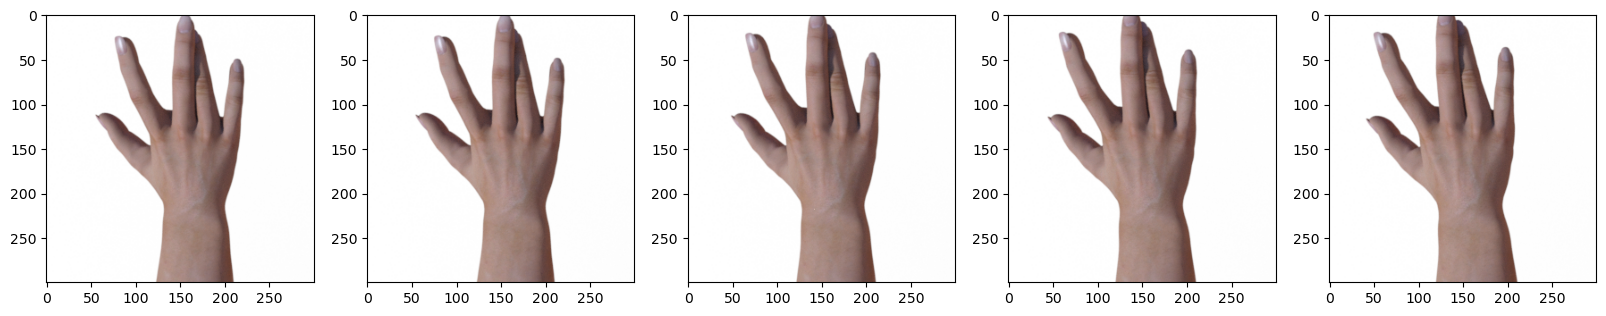

In [8]:
# Show sample image paper
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(paper_imgs[:5]):
    sp = plt.subplot(1, 5, i + 1)
    img = mpimg.imread(os.path.join(training_paper_dir, img_path))
    plt.imshow(img)
plt.show()

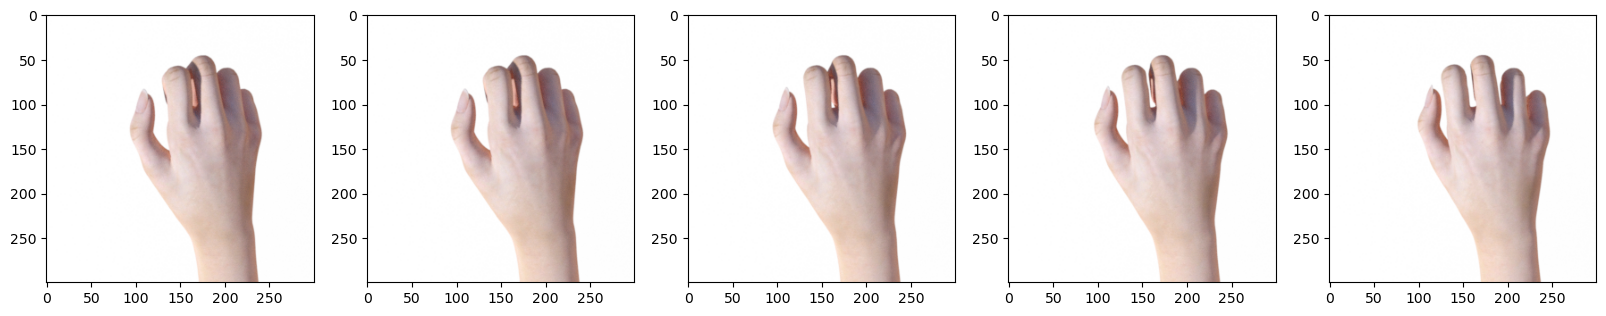

In [9]:
# Show sample image rock
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(rock_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_rock_dir, img_path))
    plt.imshow(img)
plt.show()

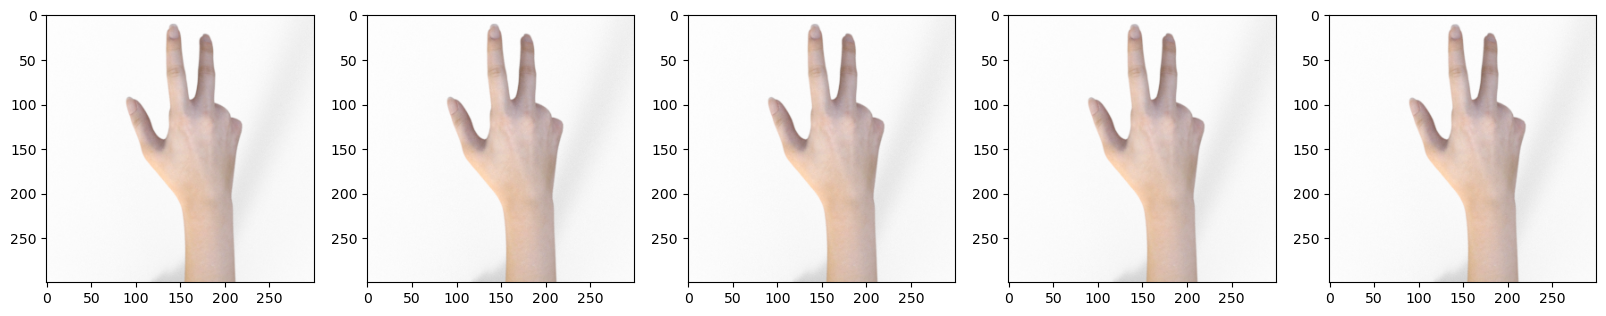

In [10]:
# Show sample image rock
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(scissors_imgs[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(training_scissors_dir, img_path))
    plt.imshow(img)
plt.show()

Augmentasi and  Dataset image

In [12]:
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.5, shear_range=0.2, zoom_range=0.2,
                                   rotation_range=20, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.5)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    classes=['paper', 'rock', 'scissors'],
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    classes=['paper', 'rock', 'scissors'],
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 1764 images belonging to 3 classes.
Found 315 images belonging to 3 classes.


In [13]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [14]:
valid_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [15]:
NUM_TRAIN_DATA = train_generator.n
NUM_VALID_DATA = valid_generator.n

Model Transfer Learning

In [16]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    AveragePooling2D(pool_size=(7,7)),
    Flatten(name="flatten"),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(3, activation = "softmax")
])



9406464/9406464 [==============================] - 8s 1us/step


In [17]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])

In [18]:
history = model.fit(train_generator, 
                    steps_per_epoch=NUM_TRAIN_DATA//32, 
                    epochs=20, 
                    validation_data=valid_generator, 
                    validation_steps=5, 
                    verbose=2)

Epoch 1/20


55/55 - 81s - loss: 0.8288 - accuracy: 0.6345 - val_loss: 0.3293 - val_accuracy: 0.9500 - 81s/epoch - 1s/step
Epoch 2/20
55/55 - 55s - loss: 0.3421 - accuracy: 0.8961 - val_loss: 0.1658 - val_accuracy: 0.9750 - 55s/epoch - 1s/step
Epoch 3/20
55/55 - 87s - loss: 0.1954 - accuracy: 0.9498 - val_loss: 0.1020 - val_accuracy: 0.9875 - 87s/epoch - 2s/step
Epoch 4/20
55/55 - 55s - loss: 0.1479 - accuracy: 0.9602 - val_loss: 0.0848 - val_accuracy: 0.9875 - 55s/epoch - 1s/step
Epoch 5/20
55/55 - 56s - loss: 0.1121 - accuracy: 0.9744 - val_loss: 0.0505 - val_accuracy: 0.9875 - 56s/epoch - 1s/step
Epoch 6/20
55/55 - 55s - loss: 0.0983 - accuracy: 0.9746 - val_loss: 0.0558 - val_accuracy: 0.9875 - 55s/epoch - 995ms/step
Epoch 7/20
55/55 - 55s - loss: 0.0777 - accuracy: 0.9809 - val_loss: 0.0261 - val_accuracy: 1.0000 - 55s/epoch - 993ms/step
Epoch 8/20
55/55 - 92s - loss: 0.0622 - accuracy: 0.9833 - val_loss: 0.0341 - val_accuracy: 0.9937 - 92s/epoch - 2s/step
Epoch 9/20
55/55 - 55s -

Evaluate Model

In [19]:
score = model.evaluate(train_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

56/56 [==============================] - 54s 963ms/step - loss: 0.0074 - accuracy: 1.0000
Loss: 0.0074
Accuracy: 1.0000


In [20]:
score = model.evaluate(valid_generator)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

10/10 [==============================] - 4s 431ms/step - loss: 0.0107 - accuracy: 0.9937
Loss: 0.0107
Accuracy: 0.9937


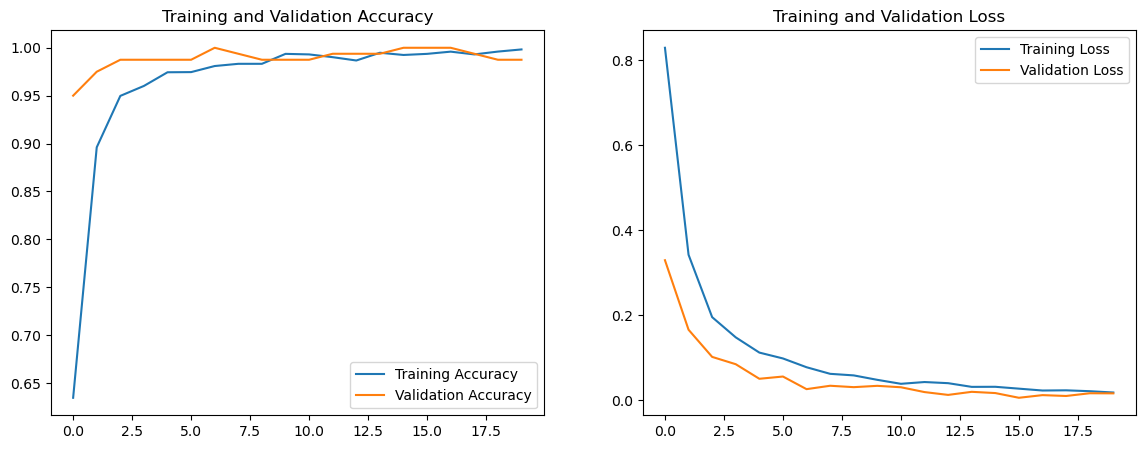

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix

10/10 [==============================] - 6s 430ms/step


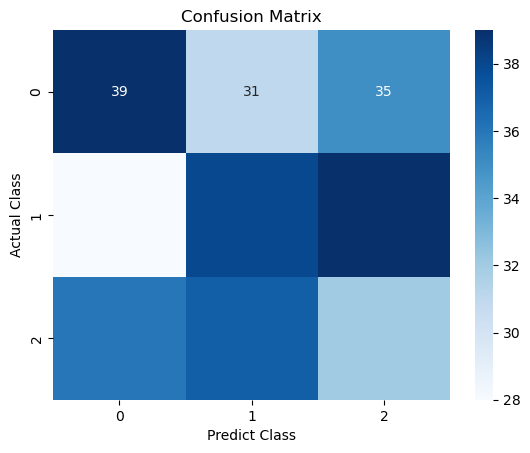

True Negative =  39
False Negative =  28
True Positive =  38
False Positive =  31


In [22]:
import seaborn as sns

Batch_size = 32

Y_prediction = model.predict(valid_generator, NUM_VALID_DATA//Batch_size+1)
y_prediction = np.argmax(Y_prediction, axis=1)

conf_matrix = confusion_matrix(valid_generator.classes, y_prediction)
confusion_array = sklearn.metrics.confusion_matrix(valid_generator.classes, y_prediction)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel('Actual Class')
plt.xlabel("Predict Class")
plt.show()

print('True Negative = ', confusion_array[0,0])
print('False Negative = ', confusion_array[1,0])
print('True Positive = ', confusion_array[1,1])
print('False Positive = ', confusion_array[0,1])

In [23]:
print('Classification Report Validation')
target_names = ['Paper', 'Rock', 'Scissors']
print(classification_report(valid_generator.classes, y_prediction, target_names=target_names))

Classification Report Validation
              precision    recall  f1-score   support

       Paper       0.38      0.37      0.37       105
        Rock       0.36      0.36      0.36       105
    Scissors       0.30      0.30      0.30       105

    accuracy                           0.35       315
   macro avg       0.35      0.35      0.35       315
weighted avg       0.35      0.35      0.35       315



Predict Test set

In [24]:
import os
import shutil

# Define the paths to the test directory and its subdirectories
test_dir = 'D:\\PERKULIAHAN\\S7\\PEMBELAJARAN MESIN\\Modul 5 - Transfer Learning\\tmp\\rockpaperscissors\\test'
paper_dir = os.path.join(test_dir, 'paper')
rock_dir = os.path.join(test_dir, 'rock')
scissors_dir = os.path.join(test_dir, 'scissors')

# Define the target directory where you want to merge the images
target_dir = os.path.join(test_dir, 'merged_test')

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# List the files in each subdirectory and move them to the target directory
for subdir in [paper_dir, rock_dir, scissors_dir]:
    for filename in os.listdir(subdir):
        source_path = os.path.join(subdir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.copy(source_path, target_path)

In [25]:
def get_class(file_name):
    # Split the file path by both forward and backward slashes
    path_components = file_name.split('/')
    path_components.extend(file_name.split('\\'))  # Extend the list with backslash splits

    # Find the last component that is not empty and use it as the class label
    for component in reversed(path_components):
        if component:
            return component
    # Return a default label if the path does not contain a valid class label
    return 'Unknown'

Found 126 images belonging to 3 classes.


1/1 [==============================] - 0s 79ms/step


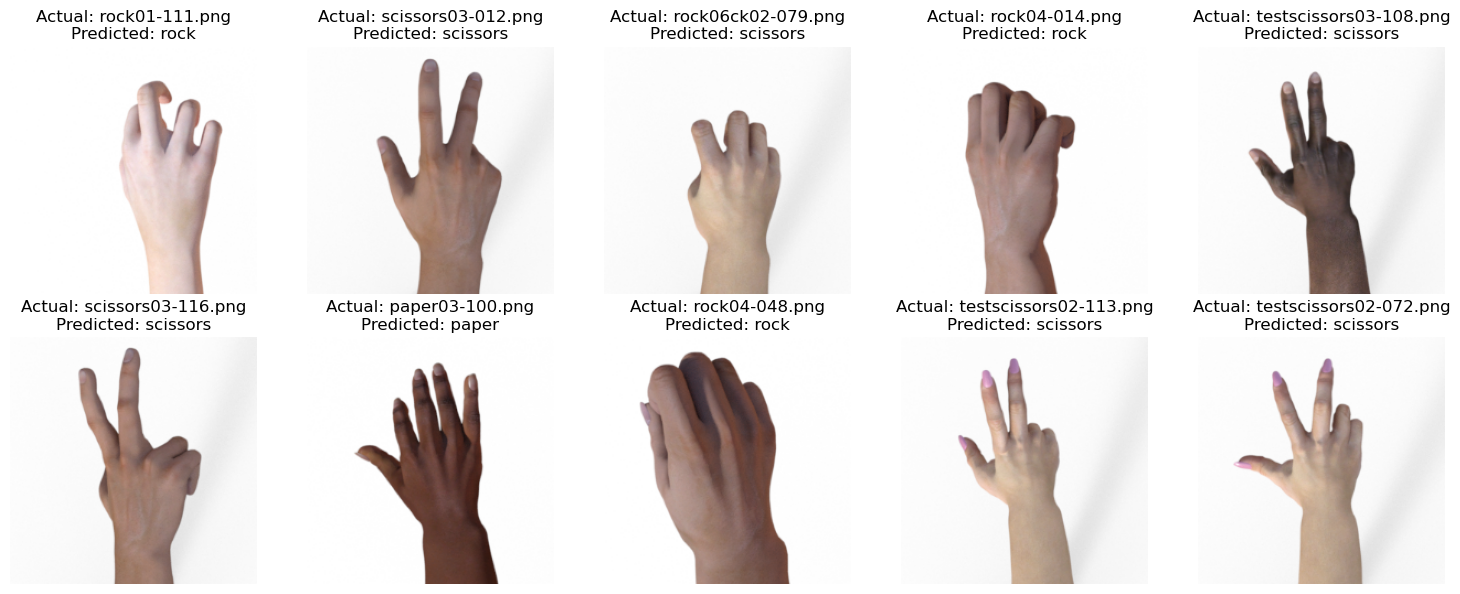

In [26]:
# Load test set
test_dir = 'D:\\PERKULIAHAN\\S7\\PEMBELAJARAN MESIN\\Modul 5 - Transfer Learning\\tmp\\rockpaperscissors\\test'
test_files = os.listdir(test_dir)

# preprocess the selected images

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

selected_test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    classes=['paper','rock', 'scissors'],
    shuffle=False
)
random_numbers = [random.randint(0, 126 - 1) for _ in range(10)]
class_labels = list(selected_test_generator.class_indices.keys())

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img_path = selected_test_generator.filepaths[random_numbers[i]]
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    prediction = model.predict(img.reshape(1, 224, 224, 3))
    predicted_label = class_labels[np.argmax(prediction)]

    actual_label = get_class(img_path)

    ax.imshow(img)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
    ax.axis('off')

plt.tight_layout()
plt.show()